In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pbn import operations as ops
%matplotlib inline

In [373]:
import matplotlib.image as matimg
#img_d = matimg.imread('/Users/eczech/Downloads/google.png')
img_d = matimg.imread('/Users/eczech/Downloads/afremov.png')

img_d.shape

(941, 698, 3)

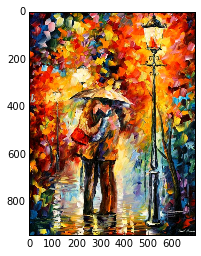

In [374]:
plt.imshow(img_d)

In [317]:
#plt.imsave('/tmp/pbn_denoise.png', ndimage.median_filter(img_d, 3))

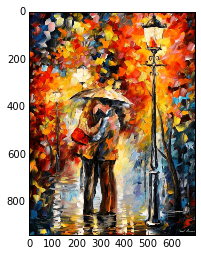

In [372]:
img_d = ndimage.median_filter(img_d, 3)
plt.imshow(img_d)

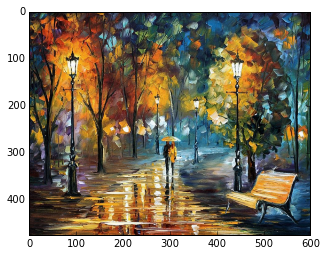

In [280]:
# blur original image test
from scipy import ndimage
img_d_test = ndimage.gaussian_filter(img_d, sigma=.5)
plt.imshow(img_d_test)
#plt.imsave('/tmp/pbn_blur.png', img_d)

In [375]:
colors = ops.unravel(img_d)
colors.head()

,R,G,B
0,50,0,20
1,72,19,39
2,89,30,50
3,85,21,38
4,76,5,19


In [386]:
preds = ops.cluster_color_space(colors, n_components=12, alpha=1, covariance_type='spherical')

# For gmm 184M of memory is used on 1000 x 1400 image and takes about 10 minutes to run
#preds = ops.cluster_color_space2(colors, n_components=50, covariance_type='diag')

preds_vc = preds.value_counts()
print('Number of clusters: {}'.format(len(preds_vc)))
preds_vc

Number of clusters: 12


11    69864
2     65030
5     63046
4     59706
0     58232
7     58227
10    54840
1     53940
8     47661
9     46477
3     40504
6     39291
dtype: int64

In [387]:
res = pd.concat([preds, colors], axis=1)
res = res.rename(columns={0: 'C'})
clusters = res.groupby('C').mean().applymap(lambda x: int(np.round(x)))
clusters.head()

,R,G,B
C,,,
0,76,22,9
1,236,189,84
2,226,72,10
3,65,94,104
4,32,44,50


(0, 200)

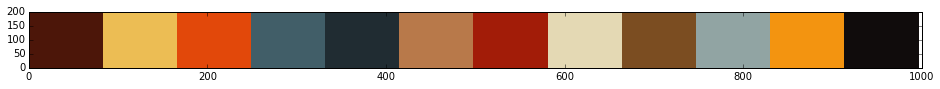

In [388]:
import matplotlib
fig = plt.figure()
fig.set_size_inches((16,1))
ax = fig.add_subplot(111)
width, height = 1000, 200
interval = int(float(width) / len(clusters))
for i, v in clusters.iterrows():
    offset = i * interval
    rect = matplotlib.patches.Rectangle((offset,0), interval, height, color=(v/float(255)))
    ax.add_patch(rect)
plt.xlim([0, width])
plt.ylim([0, height])

In [389]:
merged = res.merge(clusters, left_on='C', right_index=True, suffixes=['', '_mean'])
merged.head()

,C,R,G,B,R_mean,G_mean,B_mean
0,0,50,0,20,76,22,9
1,0,72,19,39,76,22,9
2,0,89,30,50,76,22,9
3,0,85,21,38,76,22,9
4,0,76,5,19,76,22,9


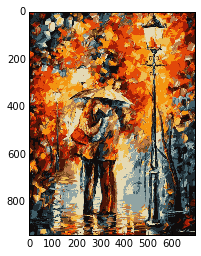

In [390]:
img_recon = ops.reravel(merged[[c for c in merged.columns if 'mean' in c]], *img_d.shape[0:2])
img_recon = img_recon / float(255)
plt.imsave('/tmp/pbn_recon.png', img_recon)
plt.imshow(img_recon)

In [393]:
plt.imsave('/tmp/pbn_recon_denoise.png', ndimage.median_filter(ndimage.median_filter(img_recon, 3), 3))

In [394]:
color_matrix = ops.reravel(merged[['C']], img_d.shape[0], img_d.shape[1])
color_matrix = np.int64(np.reshape(color_matrix, img_d.shape[0:2]))
color_matrix.shape

(941, 698)

In [401]:
spatial_clusters = ops.cluster_by_proximity(color_matrix, n_iterations=1, shrinkage=2, threshold=.5)
len(spatial_clusters)

11827 clusters collapsed of 21164


12

In [402]:
[len(c) for c in spatial_clusters.values()]

[969, 862, 498, 1019, 899, 1817, 462, 612, 1950, 956, 486, 985]

In [326]:
import imp
imp.reload(ops)

<module 'pbn.operations' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/operations.py'>

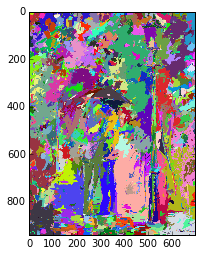

In [411]:
img_reassembled = ops.image_from_clusters(spatial_clusters, clusters, img_d, use_random_color=True)
plt.imsave('/tmp/pbn_rand.png', img_reassembled)
plt.imshow(img_reassembled)

In [404]:
cluster_props = ops.get_cluster_props(spatial_clusters, clusters, color_matrix)

In [405]:
[ len(cluster_props[cc_id]) for cc_id in cluster_props]

[969, 862, 498, 1019, 899, 1817, 462, 612, 1950, 956, 486, 985]

In [406]:
cl1 = cluster_props[0][0]
len(cl1['points']), len(cl1['edges']), cl1['color'], len(cl1['labels'])

(14301, 3152, R    76
 G    22
 B     9
 Name: 0, dtype: int64, 8734)

In [407]:
img_edge = ops.render_pbn(cluster_props, img_d, edg=[.5,.5,.5], size_limit=10, solution=True)

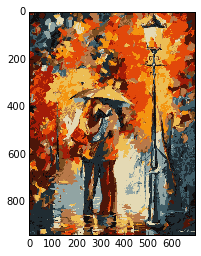

In [408]:
matimg.imsave('/tmp/pbn_test_sol.png', img_edge)
plt.imshow(img_edge)

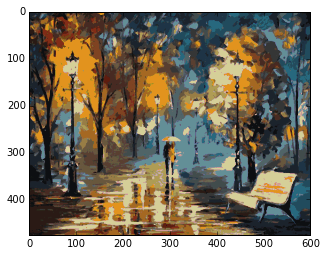

In [311]:
#img_sol = ndimage.gaussian_filter(img_edge, sigma=.5)
img_sol = ndimage.median_filter(img_edge, 3)
matimg.imsave('/tmp/pbn_test_sol2_blur.png', img_sol)
plt.imshow(img_sol)